In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [14]:
data_flag = 'breastmnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 100
BATCH_SIZE = 64
lr = 0.01

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [15]:
from torch.utils.data import DataLoader

# Augmentation for the training dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# No augmentation for validation & test sets (only normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets with appropriate transformations
train_dataset = DataClass(split='train', transform=train_transform, download=download)
validation_dataset = DataClass(split='val', transform=test_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

# Encapsulate datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 546
Validation samples: 78
Test samples: 156


In [16]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /home/oussama/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 78
    Root location: /home/oussama/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meani

In [6]:
# visualization

train_dataset.montage(length=1)

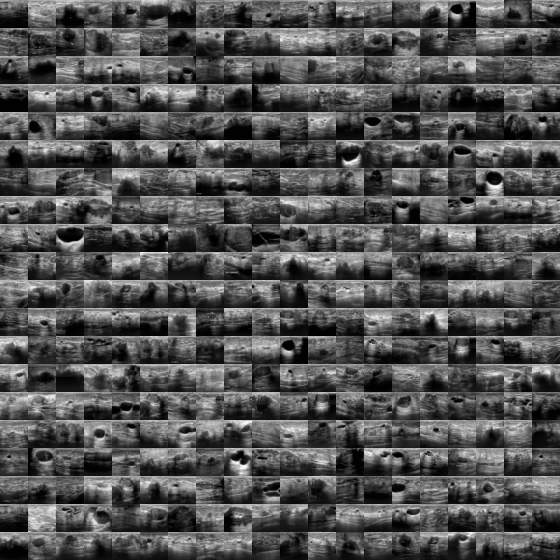

In [7]:
# montage

train_dataset.montage(length=20)

In [8]:
from PIL import Image
import numpy as np

# Get a single image from the test dataset
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Take the first image from the batch
img = images[0]
label = labels[0].item()  # Get the label as a Python number

# Print the label
print(f"Image label: {label}")

# Denormalize the image (reverse the normalization we applied)
# The formula is: image = image * std + mean
img_denormalized = img * 0.5 + 0.5  # Using the same mean=0.5, std=0.5 from your transforms

# Convert to numpy and transpose dimensions if needed
# PyTorch tensors are (C, H, W) but we need (H, W, C) for saving
if img_denormalized.shape[0] == 1:  # Grayscale image
    img_np = img_denormalized.squeeze().numpy()  # Remove channel dimension for grayscale
else:  # Color image
    img_np = img_denormalized.permute(1, 2, 0).numpy()  # Change from (C,H,W) to (H,W,C)

# Convert to uint8 for saving as image
img_np = (img_np * 255).astype(np.uint8)

# Save as PNG
if img_denormalized.shape[0] == 1:  # For grayscale images
    Image.fromarray(img_np, mode='L').save('images/breast/test_image.png')
else:  # For RGB images
    Image.fromarray(img_np).save('test_image.png')

print(f"Image saved as test_image.png")

Image label: 0
Image saved as test_image.png


In [17]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [18]:
class Square(torch.nn.Module):
    def forward(self, x):
        return x**2
    
class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

def _approximated_ReLU(x):
    return 0.117071 * x**2 + 0.5 * x + 0.375373

class ApproxReLU(torch.nn.Module):
    def forward(self, x):
        return _approximated_ReLU(x)
    

In [19]:
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [20]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [1]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")


NameError: name 'NUM_EPOCHS' is not defined

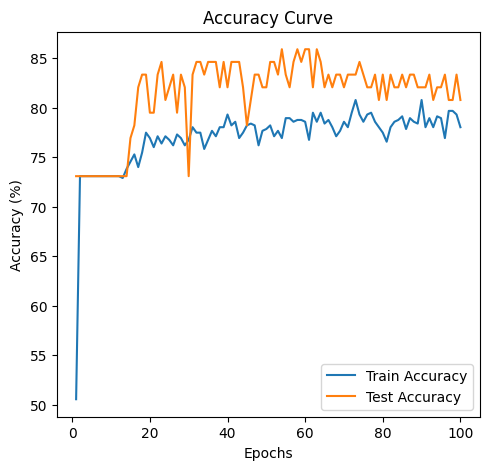

In [22]:
# Plot accuracy and loss curves
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [2]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

NameError: name 'model' is not defined

In [81]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Store attributes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Normalize activations
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with downsampling if needed
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),  # Kernel=1 to preserve spatial dimensions
                nn.BatchNorm2d(out_channels)
            )

        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Adjust identity shape if needed
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out += identity
        out = self.relu2(out)
        
        return out

In [82]:
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)  # Normalize activations
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        # self.relu2 = nn.ReLU()
        self.res1 = ResidualBlock(in_channels=6, out_channels=16, stride=1)
        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        # output = self.conv2(output)
        # output = self.relu2(output)
        output = self.res1(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [83]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [84]:
# train

for epoch in range(200):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.29it/s]



Summary: Train Loss: 0.6134, Train Acc: 65.57%, Validation Loss: 0.3066, Validation Acc: 73.08%

Epoch [2/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.73it/s]



Summary: Train Loss: 0.5555, Train Acc: 73.26%, Validation Loss: 0.2976, Validation Acc: 73.08%

Epoch [3/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.41it/s]



Summary: Train Loss: 0.5180, Train Acc: 77.29%, Validation Loss: 0.2616, Validation Acc: 73.08%

Epoch [4/100] Training...


100%|██████████| 9/9 [00:00<00:00, 33.91it/s]



Summary: Train Loss: 0.5010, Train Acc: 76.74%, Validation Loss: 0.2440, Validation Acc: 80.77%

Epoch [5/100] Training...


100%|██████████| 9/9 [00:00<00:00, 33.22it/s]



Summary: Train Loss: 0.4943, Train Acc: 78.02%, Validation Loss: 0.2322, Validation Acc: 83.33%

Epoch [6/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.93it/s]



Summary: Train Loss: 0.4872, Train Acc: 79.49%, Validation Loss: 0.2449, Validation Acc: 75.64%

Epoch [7/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.27it/s]



Summary: Train Loss: 0.4875, Train Acc: 78.21%, Validation Loss: 0.2299, Validation Acc: 80.77%

Epoch [8/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.89it/s]



Summary: Train Loss: 0.4684, Train Acc: 80.04%, Validation Loss: 0.2150, Validation Acc: 82.05%

Epoch [9/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.93it/s]



Summary: Train Loss: 0.4886, Train Acc: 77.11%, Validation Loss: 0.2213, Validation Acc: 83.33%

Epoch [10/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.53it/s]



Summary: Train Loss: 0.4826, Train Acc: 77.11%, Validation Loss: 0.2160, Validation Acc: 82.05%

Epoch [11/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.39it/s]



Summary: Train Loss: 0.4699, Train Acc: 77.47%, Validation Loss: 0.2448, Validation Acc: 74.36%

Epoch [12/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.48it/s]



Summary: Train Loss: 0.4570, Train Acc: 79.49%, Validation Loss: 0.2209, Validation Acc: 80.77%

Epoch [13/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.83it/s]



Summary: Train Loss: 0.4771, Train Acc: 78.94%, Validation Loss: 0.2220, Validation Acc: 79.49%

Epoch [14/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.45it/s]



Summary: Train Loss: 0.4583, Train Acc: 78.02%, Validation Loss: 0.2359, Validation Acc: 76.92%

Epoch [15/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.59it/s]



Summary: Train Loss: 0.4563, Train Acc: 80.22%, Validation Loss: 0.2160, Validation Acc: 84.62%

Epoch [16/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.45it/s]



Summary: Train Loss: 0.4254, Train Acc: 80.95%, Validation Loss: 0.2706, Validation Acc: 75.64%

Epoch [17/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.62it/s]



Summary: Train Loss: 0.4259, Train Acc: 79.85%, Validation Loss: 0.2250, Validation Acc: 84.62%

Epoch [18/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.31it/s]



Summary: Train Loss: 0.4719, Train Acc: 80.77%, Validation Loss: 0.2235, Validation Acc: 82.05%

Epoch [19/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.22it/s]



Summary: Train Loss: 0.4781, Train Acc: 78.39%, Validation Loss: 0.2374, Validation Acc: 82.05%

Epoch [20/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.27it/s]



Summary: Train Loss: 0.4455, Train Acc: 80.59%, Validation Loss: 0.1986, Validation Acc: 83.33%

Epoch [21/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.62it/s]



Summary: Train Loss: 0.4250, Train Acc: 82.78%, Validation Loss: 0.2302, Validation Acc: 80.77%

Epoch [22/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.10it/s]



Summary: Train Loss: 0.4658, Train Acc: 80.04%, Validation Loss: 0.2848, Validation Acc: 76.92%

Epoch [23/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.96it/s]



Summary: Train Loss: 0.4532, Train Acc: 79.67%, Validation Loss: 0.2108, Validation Acc: 82.05%

Epoch [24/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.65it/s]



Summary: Train Loss: 0.4307, Train Acc: 81.50%, Validation Loss: 0.1975, Validation Acc: 84.62%

Epoch [25/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.33it/s]



Summary: Train Loss: 0.4120, Train Acc: 81.14%, Validation Loss: 0.2294, Validation Acc: 76.92%

Epoch [26/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.27it/s]



Summary: Train Loss: 0.3767, Train Acc: 82.78%, Validation Loss: 0.3190, Validation Acc: 74.36%

Epoch [27/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.55it/s]



Summary: Train Loss: 0.4205, Train Acc: 82.23%, Validation Loss: 0.2134, Validation Acc: 84.62%

Epoch [28/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.15it/s]



Summary: Train Loss: 0.4003, Train Acc: 82.60%, Validation Loss: 0.3380, Validation Acc: 75.64%

Epoch [29/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.67it/s]



Summary: Train Loss: 0.4193, Train Acc: 80.77%, Validation Loss: 0.1991, Validation Acc: 80.77%

Epoch [30/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.75it/s]



Summary: Train Loss: 0.4110, Train Acc: 80.95%, Validation Loss: 0.2019, Validation Acc: 85.90%

Epoch [31/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.83it/s]



Summary: Train Loss: 0.4343, Train Acc: 78.21%, Validation Loss: 0.2590, Validation Acc: 73.08%

Epoch [32/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.13it/s]



Summary: Train Loss: 0.4055, Train Acc: 81.68%, Validation Loss: 0.2201, Validation Acc: 80.77%

Epoch [33/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.70it/s]



Summary: Train Loss: 0.3931, Train Acc: 82.97%, Validation Loss: 0.1947, Validation Acc: 82.05%

Epoch [34/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.85it/s]



Summary: Train Loss: 0.3662, Train Acc: 83.70%, Validation Loss: 0.2117, Validation Acc: 80.77%

Epoch [35/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.09it/s]



Summary: Train Loss: 0.3822, Train Acc: 84.25%, Validation Loss: 0.1721, Validation Acc: 85.90%

Epoch [36/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.68it/s]



Summary: Train Loss: 0.3997, Train Acc: 83.15%, Validation Loss: 0.1859, Validation Acc: 83.33%

Epoch [37/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.24it/s]



Summary: Train Loss: 0.3588, Train Acc: 84.43%, Validation Loss: 0.1962, Validation Acc: 84.62%

Epoch [38/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.86it/s]



Summary: Train Loss: 0.3911, Train Acc: 82.78%, Validation Loss: 0.2155, Validation Acc: 80.77%

Epoch [39/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.23it/s]



Summary: Train Loss: 0.4039, Train Acc: 84.07%, Validation Loss: 0.3956, Validation Acc: 75.64%

Epoch [40/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.90it/s]



Summary: Train Loss: 0.3892, Train Acc: 84.80%, Validation Loss: 0.2605, Validation Acc: 76.92%

Epoch [41/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.45it/s]



Summary: Train Loss: 0.3776, Train Acc: 84.62%, Validation Loss: 0.2523, Validation Acc: 73.08%

Epoch [42/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.83it/s]



Summary: Train Loss: 0.3671, Train Acc: 84.98%, Validation Loss: 0.2145, Validation Acc: 79.49%

Epoch [43/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.59it/s]



Summary: Train Loss: 0.3790, Train Acc: 84.25%, Validation Loss: 0.2817, Validation Acc: 78.21%

Epoch [44/100] Training...


100%|██████████| 9/9 [00:00<00:00, 24.71it/s]



Summary: Train Loss: 0.3466, Train Acc: 84.07%, Validation Loss: 0.1766, Validation Acc: 83.33%

Epoch [45/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.12it/s]



Summary: Train Loss: 0.3866, Train Acc: 83.33%, Validation Loss: 0.2357, Validation Acc: 82.05%

Epoch [46/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.86it/s]



Summary: Train Loss: 0.3977, Train Acc: 83.15%, Validation Loss: 0.1953, Validation Acc: 80.77%

Epoch [47/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.04it/s]



Summary: Train Loss: 0.3978, Train Acc: 83.15%, Validation Loss: 0.1955, Validation Acc: 80.77%

Epoch [48/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.97it/s]



Summary: Train Loss: 0.3760, Train Acc: 84.07%, Validation Loss: 0.2091, Validation Acc: 80.77%

Epoch [49/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.56it/s]



Summary: Train Loss: 0.3518, Train Acc: 84.43%, Validation Loss: 0.1943, Validation Acc: 83.33%

Epoch [50/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.03it/s]



Summary: Train Loss: 0.3382, Train Acc: 85.71%, Validation Loss: 0.2122, Validation Acc: 80.77%

Epoch [51/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.17it/s]



Summary: Train Loss: 0.3823, Train Acc: 84.07%, Validation Loss: 0.1871, Validation Acc: 79.49%

Epoch [52/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.83it/s]



Summary: Train Loss: 0.4008, Train Acc: 83.15%, Validation Loss: 0.3109, Validation Acc: 78.21%

Epoch [53/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.16it/s]



Summary: Train Loss: 0.3851, Train Acc: 84.98%, Validation Loss: 0.2178, Validation Acc: 80.77%

Epoch [54/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.42it/s]



Summary: Train Loss: 0.3587, Train Acc: 84.62%, Validation Loss: 0.1709, Validation Acc: 87.18%

Epoch [55/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.33it/s]



Summary: Train Loss: 0.3392, Train Acc: 84.98%, Validation Loss: 0.1992, Validation Acc: 83.33%

Epoch [56/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.51it/s]



Summary: Train Loss: 0.3379, Train Acc: 85.90%, Validation Loss: 0.1855, Validation Acc: 83.33%

Epoch [57/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.43it/s]



Summary: Train Loss: 0.3398, Train Acc: 86.81%, Validation Loss: 0.2293, Validation Acc: 82.05%

Epoch [58/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.92it/s]



Summary: Train Loss: 0.3439, Train Acc: 85.35%, Validation Loss: 0.1666, Validation Acc: 87.18%

Epoch [59/100] Training...


100%|██████████| 9/9 [00:00<00:00, 24.94it/s]



Summary: Train Loss: 0.3244, Train Acc: 84.98%, Validation Loss: 0.2516, Validation Acc: 75.64%

Epoch [60/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.89it/s]



Summary: Train Loss: 0.3163, Train Acc: 86.81%, Validation Loss: 0.4080, Validation Acc: 73.08%

Epoch [61/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.15it/s]



Summary: Train Loss: 0.3273, Train Acc: 86.81%, Validation Loss: 0.2368, Validation Acc: 82.05%

Epoch [62/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.03it/s]



Summary: Train Loss: 0.3047, Train Acc: 87.36%, Validation Loss: 0.3248, Validation Acc: 76.92%

Epoch [63/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.13it/s]



Summary: Train Loss: 0.3092, Train Acc: 87.18%, Validation Loss: 0.2079, Validation Acc: 80.77%

Epoch [64/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.57it/s]



Summary: Train Loss: 0.3292, Train Acc: 86.45%, Validation Loss: 0.1835, Validation Acc: 84.62%

Epoch [65/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.83it/s]



Summary: Train Loss: 0.2859, Train Acc: 87.91%, Validation Loss: 0.4705, Validation Acc: 73.08%

Epoch [66/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.80it/s]



Summary: Train Loss: 0.2814, Train Acc: 87.36%, Validation Loss: 0.1824, Validation Acc: 85.90%

Epoch [67/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.99it/s]



Summary: Train Loss: 0.3068, Train Acc: 86.63%, Validation Loss: 0.2627, Validation Acc: 79.49%

Epoch [68/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.45it/s]



Summary: Train Loss: 0.3399, Train Acc: 86.45%, Validation Loss: 0.1848, Validation Acc: 87.18%

Epoch [69/100] Training...


100%|██████████| 9/9 [00:00<00:00, 23.85it/s]



Summary: Train Loss: 0.3333, Train Acc: 85.53%, Validation Loss: 0.1760, Validation Acc: 83.33%

Epoch [70/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.45it/s]



Summary: Train Loss: 0.3289, Train Acc: 87.00%, Validation Loss: 0.1811, Validation Acc: 82.05%

Epoch [71/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.95it/s]



Summary: Train Loss: 0.2886, Train Acc: 88.83%, Validation Loss: 0.1616, Validation Acc: 87.18%

Epoch [72/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.71it/s]



Summary: Train Loss: 0.2946, Train Acc: 88.10%, Validation Loss: 0.1789, Validation Acc: 88.46%

Epoch [73/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.79it/s]



Summary: Train Loss: 0.3045, Train Acc: 87.55%, Validation Loss: 0.1468, Validation Acc: 85.90%

Epoch [74/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.52it/s]



Summary: Train Loss: 0.2972, Train Acc: 87.91%, Validation Loss: 0.1655, Validation Acc: 87.18%

Epoch [75/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.81it/s]



Summary: Train Loss: 0.2667, Train Acc: 88.28%, Validation Loss: 0.3087, Validation Acc: 76.92%

Epoch [76/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.17it/s]



Summary: Train Loss: 0.3075, Train Acc: 87.00%, Validation Loss: 0.2611, Validation Acc: 82.05%

Epoch [77/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.37it/s]



Summary: Train Loss: 0.3187, Train Acc: 86.45%, Validation Loss: 0.2475, Validation Acc: 79.49%

Epoch [78/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.02it/s]



Summary: Train Loss: 0.2862, Train Acc: 88.28%, Validation Loss: 0.2075, Validation Acc: 83.33%

Epoch [79/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.71it/s]



Summary: Train Loss: 0.3417, Train Acc: 85.16%, Validation Loss: 0.1974, Validation Acc: 84.62%

Epoch [80/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.18it/s]



Summary: Train Loss: 0.2913, Train Acc: 88.46%, Validation Loss: 0.2385, Validation Acc: 76.92%

Epoch [81/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.38it/s]



Summary: Train Loss: 0.2909, Train Acc: 86.81%, Validation Loss: 0.3044, Validation Acc: 78.21%

Epoch [82/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.92it/s]



Summary: Train Loss: 0.3054, Train Acc: 87.36%, Validation Loss: 0.1893, Validation Acc: 87.18%

Epoch [83/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.20it/s]



Summary: Train Loss: 0.2729, Train Acc: 89.56%, Validation Loss: 0.1702, Validation Acc: 87.18%

Epoch [84/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.60it/s]



Summary: Train Loss: 0.2828, Train Acc: 88.83%, Validation Loss: 0.1630, Validation Acc: 87.18%

Epoch [85/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.04it/s]



Summary: Train Loss: 0.2614, Train Acc: 87.73%, Validation Loss: 0.2037, Validation Acc: 85.90%

Epoch [86/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.92it/s]



Summary: Train Loss: 0.2534, Train Acc: 89.74%, Validation Loss: 0.2098, Validation Acc: 87.18%

Epoch [87/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.21it/s]



Summary: Train Loss: 0.2485, Train Acc: 88.64%, Validation Loss: 0.3092, Validation Acc: 79.49%

Epoch [88/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.89it/s]



Summary: Train Loss: 0.2844, Train Acc: 87.18%, Validation Loss: 0.2506, Validation Acc: 84.62%

Epoch [89/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.80it/s]



Summary: Train Loss: 0.2691, Train Acc: 89.38%, Validation Loss: 0.2191, Validation Acc: 83.33%

Epoch [90/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.81it/s]



Summary: Train Loss: 0.3083, Train Acc: 85.90%, Validation Loss: 0.3059, Validation Acc: 78.21%

Epoch [91/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.87it/s]



Summary: Train Loss: 0.3144, Train Acc: 86.26%, Validation Loss: 0.2455, Validation Acc: 85.90%

Epoch [92/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.57it/s]



Summary: Train Loss: 0.2907, Train Acc: 89.56%, Validation Loss: 0.1779, Validation Acc: 83.33%

Epoch [93/100] Training...


100%|██████████| 9/9 [00:00<00:00, 24.92it/s]



Summary: Train Loss: 0.2869, Train Acc: 86.63%, Validation Loss: 0.2334, Validation Acc: 82.05%

Epoch [94/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.32it/s]



Summary: Train Loss: 0.3178, Train Acc: 88.64%, Validation Loss: 0.2144, Validation Acc: 84.62%

Epoch [95/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.90it/s]



Summary: Train Loss: 0.2465, Train Acc: 90.29%, Validation Loss: 0.1791, Validation Acc: 87.18%

Epoch [96/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.87it/s]



Summary: Train Loss: 0.2375, Train Acc: 90.48%, Validation Loss: 0.2107, Validation Acc: 80.77%

Epoch [97/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.98it/s]



Summary: Train Loss: 0.2690, Train Acc: 88.28%, Validation Loss: 0.1899, Validation Acc: 87.18%

Epoch [98/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.49it/s]



Summary: Train Loss: 0.2397, Train Acc: 89.19%, Validation Loss: 0.3113, Validation Acc: 83.33%

Epoch [99/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.85it/s]



Summary: Train Loss: 0.2621, Train Acc: 89.01%, Validation Loss: 0.1969, Validation Acc: 84.62%

Epoch [100/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.04it/s]



Summary: Train Loss: 0.2990, Train Acc: 87.18%, Validation Loss: 0.3222, Validation Acc: 79.49%

Epoch [101/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.56it/s]



Summary: Train Loss: 0.2613, Train Acc: 88.83%, Validation Loss: 0.2137, Validation Acc: 84.62%

Epoch [102/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.47it/s]



Summary: Train Loss: 0.2865, Train Acc: 88.64%, Validation Loss: 0.2469, Validation Acc: 80.77%

Epoch [103/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.73it/s]



Summary: Train Loss: 0.2987, Train Acc: 86.63%, Validation Loss: 0.2017, Validation Acc: 84.62%

Epoch [104/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.75it/s]



Summary: Train Loss: 0.2777, Train Acc: 88.28%, Validation Loss: 0.1840, Validation Acc: 82.05%

Epoch [105/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.67it/s]



Summary: Train Loss: 0.2547, Train Acc: 89.38%, Validation Loss: 0.2419, Validation Acc: 83.33%

Epoch [106/100] Training...


100%|██████████| 9/9 [00:00<00:00, 24.34it/s]



Summary: Train Loss: 0.2316, Train Acc: 89.74%, Validation Loss: 0.2025, Validation Acc: 88.46%

Epoch [107/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.10it/s]



Summary: Train Loss: 0.2515, Train Acc: 90.29%, Validation Loss: 0.1969, Validation Acc: 82.05%

Epoch [108/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.28it/s]



Summary: Train Loss: 0.2288, Train Acc: 89.38%, Validation Loss: 0.1989, Validation Acc: 87.18%

Epoch [109/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.66it/s]



Summary: Train Loss: 0.2258, Train Acc: 92.49%, Validation Loss: 0.2067, Validation Acc: 84.62%

Epoch [110/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.36it/s]



Summary: Train Loss: 0.2788, Train Acc: 88.83%, Validation Loss: 0.1772, Validation Acc: 84.62%

Epoch [111/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.25it/s]



Summary: Train Loss: 0.2797, Train Acc: 89.56%, Validation Loss: 0.2536, Validation Acc: 80.77%

Epoch [112/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.73it/s]



Summary: Train Loss: 0.2589, Train Acc: 88.83%, Validation Loss: 0.2655, Validation Acc: 85.90%

Epoch [113/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.92it/s]



Summary: Train Loss: 0.3158, Train Acc: 87.00%, Validation Loss: 0.1859, Validation Acc: 89.74%

Epoch [114/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.47it/s]



Summary: Train Loss: 0.3082, Train Acc: 85.53%, Validation Loss: 0.1901, Validation Acc: 87.18%

Epoch [115/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.29it/s]



Summary: Train Loss: 0.2373, Train Acc: 89.74%, Validation Loss: 0.2079, Validation Acc: 84.62%

Epoch [116/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.72it/s]



Summary: Train Loss: 0.2582, Train Acc: 89.01%, Validation Loss: 0.1968, Validation Acc: 87.18%

Epoch [117/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.19it/s]



Summary: Train Loss: 0.2465, Train Acc: 90.29%, Validation Loss: 0.1930, Validation Acc: 84.62%

Epoch [118/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.49it/s]



Summary: Train Loss: 0.2508, Train Acc: 89.74%, Validation Loss: 0.2216, Validation Acc: 84.62%

Epoch [119/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.73it/s]



Summary: Train Loss: 0.1952, Train Acc: 92.31%, Validation Loss: 0.1736, Validation Acc: 85.90%

Epoch [120/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.69it/s]



Summary: Train Loss: 0.2007, Train Acc: 93.04%, Validation Loss: 0.2181, Validation Acc: 87.18%

Epoch [121/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.05it/s]



Summary: Train Loss: 0.2308, Train Acc: 91.21%, Validation Loss: 0.1995, Validation Acc: 87.18%

Epoch [122/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.96it/s]



Summary: Train Loss: 0.2541, Train Acc: 90.29%, Validation Loss: 0.2091, Validation Acc: 85.90%

Epoch [123/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.66it/s]



Summary: Train Loss: 0.2180, Train Acc: 91.03%, Validation Loss: 0.2067, Validation Acc: 85.90%

Epoch [124/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.77it/s]



Summary: Train Loss: 0.2558, Train Acc: 89.56%, Validation Loss: 0.2478, Validation Acc: 85.90%

Epoch [125/100] Training...


100%|██████████| 9/9 [00:00<00:00, 31.47it/s]



Summary: Train Loss: 0.2157, Train Acc: 89.74%, Validation Loss: 0.1989, Validation Acc: 85.90%

Epoch [126/100] Training...


100%|██████████| 9/9 [00:00<00:00, 32.54it/s]



Summary: Train Loss: 0.2154, Train Acc: 89.56%, Validation Loss: 0.2275, Validation Acc: 85.90%

Epoch [127/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.37it/s]



Summary: Train Loss: 0.2737, Train Acc: 87.55%, Validation Loss: 0.2280, Validation Acc: 79.49%

Epoch [128/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.73it/s]



Summary: Train Loss: 0.2009, Train Acc: 91.21%, Validation Loss: 0.2199, Validation Acc: 83.33%

Epoch [129/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.74it/s]



Summary: Train Loss: 0.2196, Train Acc: 90.84%, Validation Loss: 0.2024, Validation Acc: 84.62%

Epoch [130/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.83it/s]



Summary: Train Loss: 0.1976, Train Acc: 92.67%, Validation Loss: 0.2061, Validation Acc: 88.46%

Epoch [131/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.81it/s]



Summary: Train Loss: 0.2070, Train Acc: 90.84%, Validation Loss: 0.1942, Validation Acc: 88.46%

Epoch [132/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.42it/s]



Summary: Train Loss: 0.2381, Train Acc: 91.58%, Validation Loss: 0.2218, Validation Acc: 83.33%

Epoch [133/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.24it/s]



Summary: Train Loss: 0.2150, Train Acc: 90.84%, Validation Loss: 0.3207, Validation Acc: 82.05%

Epoch [134/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.27it/s]



Summary: Train Loss: 0.2092, Train Acc: 91.94%, Validation Loss: 0.2606, Validation Acc: 82.05%

Epoch [135/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.89it/s]



Summary: Train Loss: 0.2145, Train Acc: 91.58%, Validation Loss: 0.2147, Validation Acc: 85.90%

Epoch [136/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.84it/s]



Summary: Train Loss: 0.2343, Train Acc: 89.38%, Validation Loss: 0.2078, Validation Acc: 84.62%

Epoch [137/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.66it/s]



Summary: Train Loss: 0.2463, Train Acc: 91.03%, Validation Loss: 0.1952, Validation Acc: 85.90%

Epoch [138/100] Training...


100%|██████████| 9/9 [00:00<00:00, 23.93it/s]



Summary: Train Loss: 0.2459, Train Acc: 89.74%, Validation Loss: 0.2256, Validation Acc: 84.62%

Epoch [139/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.78it/s]



Summary: Train Loss: 0.1922, Train Acc: 92.86%, Validation Loss: 0.4942, Validation Acc: 79.49%

Epoch [140/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.02it/s]



Summary: Train Loss: 0.2373, Train Acc: 90.66%, Validation Loss: 0.2002, Validation Acc: 85.90%

Epoch [141/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.70it/s]



Summary: Train Loss: 0.2179, Train Acc: 90.84%, Validation Loss: 0.1914, Validation Acc: 89.74%

Epoch [142/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.24it/s]



Summary: Train Loss: 0.2124, Train Acc: 91.76%, Validation Loss: 0.2418, Validation Acc: 83.33%

Epoch [143/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.30it/s]



Summary: Train Loss: 0.1991, Train Acc: 91.39%, Validation Loss: 0.1968, Validation Acc: 84.62%

Epoch [144/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.97it/s]



Summary: Train Loss: 0.2375, Train Acc: 91.76%, Validation Loss: 0.2163, Validation Acc: 85.90%

Epoch [145/100] Training...


100%|██████████| 9/9 [00:00<00:00, 24.87it/s]



Summary: Train Loss: 0.1870, Train Acc: 93.41%, Validation Loss: 0.2369, Validation Acc: 84.62%

Epoch [146/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.29it/s]



Summary: Train Loss: 0.2015, Train Acc: 92.31%, Validation Loss: 0.2134, Validation Acc: 87.18%

Epoch [147/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.63it/s]



Summary: Train Loss: 0.1893, Train Acc: 92.12%, Validation Loss: 0.2386, Validation Acc: 84.62%

Epoch [148/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.34it/s]



Summary: Train Loss: 0.2300, Train Acc: 89.93%, Validation Loss: 0.2392, Validation Acc: 82.05%

Epoch [149/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.26it/s]



Summary: Train Loss: 0.2440, Train Acc: 90.11%, Validation Loss: 0.2042, Validation Acc: 87.18%

Epoch [150/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.65it/s]



Summary: Train Loss: 0.2015, Train Acc: 92.31%, Validation Loss: 0.2150, Validation Acc: 84.62%

Epoch [151/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.77it/s]



Summary: Train Loss: 0.2627, Train Acc: 89.74%, Validation Loss: 0.2756, Validation Acc: 83.33%

Epoch [152/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.15it/s]



Summary: Train Loss: 0.2009, Train Acc: 92.12%, Validation Loss: 0.2658, Validation Acc: 85.90%

Epoch [153/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.84it/s]



Summary: Train Loss: 0.2115, Train Acc: 91.21%, Validation Loss: 0.2249, Validation Acc: 85.90%

Epoch [154/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.13it/s]



Summary: Train Loss: 0.2015, Train Acc: 92.31%, Validation Loss: 0.2090, Validation Acc: 85.90%

Epoch [155/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.44it/s]



Summary: Train Loss: 0.1879, Train Acc: 92.49%, Validation Loss: 0.2417, Validation Acc: 85.90%

Epoch [156/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.62it/s]



Summary: Train Loss: 0.2058, Train Acc: 92.12%, Validation Loss: 0.2261, Validation Acc: 85.90%

Epoch [157/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.82it/s]



Summary: Train Loss: 0.1976, Train Acc: 92.12%, Validation Loss: 0.2328, Validation Acc: 82.05%

Epoch [158/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.82it/s]



Summary: Train Loss: 0.2389, Train Acc: 91.39%, Validation Loss: 0.2214, Validation Acc: 87.18%

Epoch [159/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.57it/s]



Summary: Train Loss: 0.2192, Train Acc: 92.31%, Validation Loss: 0.2158, Validation Acc: 87.18%

Epoch [160/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.02it/s]



Summary: Train Loss: 0.1861, Train Acc: 92.86%, Validation Loss: 0.1876, Validation Acc: 85.90%

Epoch [161/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.90it/s]



Summary: Train Loss: 0.1918, Train Acc: 93.41%, Validation Loss: 0.2136, Validation Acc: 85.90%

Epoch [162/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.10it/s]



Summary: Train Loss: 0.1772, Train Acc: 93.22%, Validation Loss: 0.2619, Validation Acc: 85.90%

Epoch [163/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.77it/s]



Summary: Train Loss: 0.1505, Train Acc: 93.96%, Validation Loss: 0.2529, Validation Acc: 85.90%

Epoch [164/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.03it/s]



Summary: Train Loss: 0.1696, Train Acc: 93.41%, Validation Loss: 0.2133, Validation Acc: 84.62%

Epoch [165/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.68it/s]



Summary: Train Loss: 0.2124, Train Acc: 90.48%, Validation Loss: 0.2543, Validation Acc: 83.33%

Epoch [166/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.92it/s]



Summary: Train Loss: 0.2365, Train Acc: 89.93%, Validation Loss: 0.2387, Validation Acc: 85.90%

Epoch [167/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.25it/s]



Summary: Train Loss: 0.2203, Train Acc: 90.66%, Validation Loss: 0.1693, Validation Acc: 89.74%

Epoch [168/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.62it/s]



Summary: Train Loss: 0.2074, Train Acc: 91.03%, Validation Loss: 0.1534, Validation Acc: 91.03%

Epoch [169/100] Training...


100%|██████████| 9/9 [00:00<00:00, 24.39it/s]



Summary: Train Loss: 0.2010, Train Acc: 91.76%, Validation Loss: 0.1822, Validation Acc: 89.74%

Epoch [170/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.41it/s]



Summary: Train Loss: 0.1784, Train Acc: 92.12%, Validation Loss: 0.1732, Validation Acc: 91.03%

Epoch [171/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.79it/s]



Summary: Train Loss: 0.2000, Train Acc: 92.67%, Validation Loss: 0.2361, Validation Acc: 87.18%

Epoch [172/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.20it/s]



Summary: Train Loss: 0.1955, Train Acc: 91.76%, Validation Loss: 0.2624, Validation Acc: 84.62%

Epoch [173/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.03it/s]



Summary: Train Loss: 0.1749, Train Acc: 92.49%, Validation Loss: 0.2592, Validation Acc: 83.33%

Epoch [174/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.92it/s]



Summary: Train Loss: 0.2314, Train Acc: 91.21%, Validation Loss: 0.2176, Validation Acc: 83.33%

Epoch [175/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.02it/s]



Summary: Train Loss: 0.2175, Train Acc: 91.94%, Validation Loss: 0.1499, Validation Acc: 91.03%

Epoch [176/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.24it/s]



Summary: Train Loss: 0.2380, Train Acc: 90.84%, Validation Loss: 0.2771, Validation Acc: 83.33%

Epoch [177/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.48it/s]



Summary: Train Loss: 0.1980, Train Acc: 92.31%, Validation Loss: 0.2048, Validation Acc: 89.74%

Epoch [178/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.52it/s]



Summary: Train Loss: 0.2321, Train Acc: 89.74%, Validation Loss: 0.1763, Validation Acc: 87.18%

Epoch [179/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.85it/s]



Summary: Train Loss: 0.1975, Train Acc: 91.58%, Validation Loss: 0.2240, Validation Acc: 84.62%

Epoch [180/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.21it/s]



Summary: Train Loss: 0.1843, Train Acc: 93.59%, Validation Loss: 0.2210, Validation Acc: 84.62%

Epoch [181/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.24it/s]



Summary: Train Loss: 0.1705, Train Acc: 93.04%, Validation Loss: 0.2068, Validation Acc: 85.90%

Epoch [182/100] Training...


100%|██████████| 9/9 [00:00<00:00, 26.44it/s]



Summary: Train Loss: 0.1753, Train Acc: 93.22%, Validation Loss: 0.1871, Validation Acc: 88.46%

Epoch [183/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.80it/s]



Summary: Train Loss: 0.1851, Train Acc: 92.67%, Validation Loss: 0.2056, Validation Acc: 88.46%

Epoch [184/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.79it/s]



Summary: Train Loss: 0.1683, Train Acc: 93.04%, Validation Loss: 0.2699, Validation Acc: 82.05%

Epoch [185/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.31it/s]



Summary: Train Loss: 0.1608, Train Acc: 94.51%, Validation Loss: 0.2783, Validation Acc: 85.90%

Epoch [186/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.80it/s]



Summary: Train Loss: 0.2114, Train Acc: 91.94%, Validation Loss: 0.1747, Validation Acc: 89.74%

Epoch [187/100] Training...


100%|██████████| 9/9 [00:00<00:00, 28.27it/s]



Summary: Train Loss: 0.1572, Train Acc: 94.32%, Validation Loss: 0.2517, Validation Acc: 84.62%

Epoch [188/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.66it/s]



Summary: Train Loss: 0.1862, Train Acc: 92.67%, Validation Loss: 0.1928, Validation Acc: 85.90%

Epoch [189/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.61it/s]



Summary: Train Loss: 0.1864, Train Acc: 92.86%, Validation Loss: 0.1945, Validation Acc: 84.62%

Epoch [190/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.17it/s]



Summary: Train Loss: 0.1314, Train Acc: 94.32%, Validation Loss: 0.2119, Validation Acc: 88.46%

Epoch [191/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.39it/s]



Summary: Train Loss: 0.1542, Train Acc: 93.59%, Validation Loss: 0.1622, Validation Acc: 85.90%

Epoch [192/100] Training...


100%|██████████| 9/9 [00:00<00:00, 27.20it/s]



Summary: Train Loss: 0.1253, Train Acc: 95.24%, Validation Loss: 0.2080, Validation Acc: 85.90%

Epoch [193/100] Training...


100%|██████████| 9/9 [00:00<00:00, 25.96it/s]



Summary: Train Loss: 0.1906, Train Acc: 92.67%, Validation Loss: 0.2394, Validation Acc: 83.33%

Epoch [194/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.66it/s]



Summary: Train Loss: 0.1814, Train Acc: 91.94%, Validation Loss: 0.2540, Validation Acc: 85.90%

Epoch [195/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.76it/s]



Summary: Train Loss: 0.2210, Train Acc: 91.94%, Validation Loss: 0.1915, Validation Acc: 87.18%

Epoch [196/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.72it/s]



Summary: Train Loss: 0.1950, Train Acc: 92.49%, Validation Loss: 0.2518, Validation Acc: 83.33%

Epoch [197/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.44it/s]



Summary: Train Loss: 0.1751, Train Acc: 93.04%, Validation Loss: 0.1826, Validation Acc: 88.46%

Epoch [198/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.64it/s]



Summary: Train Loss: 0.1573, Train Acc: 93.96%, Validation Loss: 0.1853, Validation Acc: 87.18%

Epoch [199/100] Training...


100%|██████████| 9/9 [00:00<00:00, 29.06it/s]



Summary: Train Loss: 0.1503, Train Acc: 94.69%, Validation Loss: 0.4582, Validation Acc: 83.33%

Epoch [200/100] Training...


100%|██████████| 9/9 [00:00<00:00, 30.10it/s]


Summary: Train Loss: 0.1347, Train Acc: 94.14%, Validation Loss: 0.2179, Validation Acc: 84.62%


In [85]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Testing the model on the test dataset...

Final Test Results: Loss: 0.8073, Accuracy: 83.97%


# checking a 2D dataset with size 64x64

In [43]:
data_flag = 'breastmnist'
# data_flag = 'breastmnist'
download = True
size=64
mmap_mode='r'

NUM_EPOCHS = 100
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [44]:
from torch.utils.data import DataLoader

# Augmentation for the training dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# No augmentation for validation & test sets (only normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets with appropriate transformations
train_dataset = DataClass(split='train', transform=train_transform, download=download, size=size, mmap_mode=mmap_mode)
validation_dataset = DataClass(split='val', transform=test_transform, download=download, size=size, mmap_mode=mmap_mode)
test_dataset = DataClass(split='test', transform=test_transform, download=download, size=size, mmap_mode=mmap_mode)

# Encapsulate datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")


100%|██████████| 2846041/2846041 [00:08<00:00, 354044.17it/s]


Using downloaded and verified file: /home/oussama/.medmnist/breastmnist_64.npz
Using downloaded and verified file: /home/oussama/.medmnist/breastmnist_64.npz
Training samples: 546
Validation samples: 78
Test samples: 156


In [45]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 64 (breastmnist_64)
    Number of datapoints: 546
    Root location: /home/oussama/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 64 (breastmnist_64)
    Number of datapoints: 78
    Root location: /home/oussama/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
   

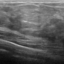

In [46]:
# visualization

train_dataset.montage(length=1)

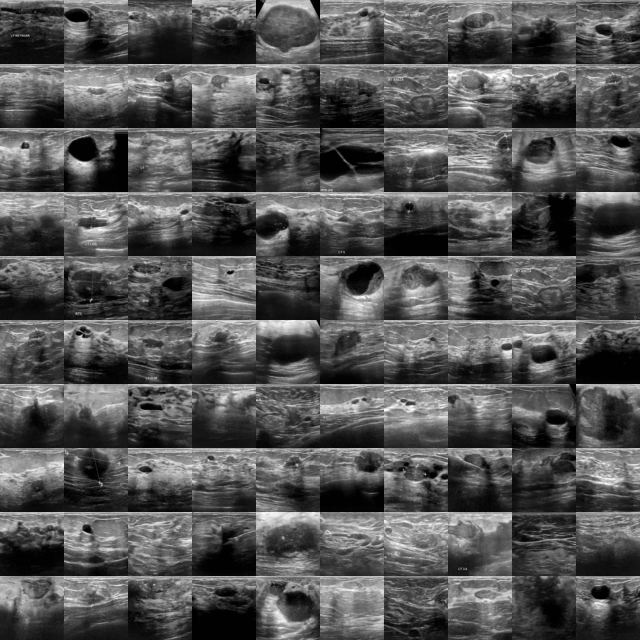

In [48]:
# visualization

train_dataset.montage(length=10)

In [10]:
import torchvision.models as models
from collections import OrderedDict

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=n_classes, bias=True)
model.to(device)

/home/oussama/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/oussama/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# resnet18

In [10]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

In [35]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Store attributes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        # Main path
        self.res_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.res_bn1 = nn.BatchNorm2d(out_channels)  # Normalize activations
        self.res_relu1 = nn.ReLU()

        self.res_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.res_bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with downsampling if needed
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),  # Kernel=1 to preserve spatial dimensions
                nn.BatchNorm2d(out_channels)
            )

        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main path
        out = self.res_conv1(x)
        out = self.res_bn1(out)
        out = self.res_relu1(out)
        

        out = self.res_conv2(out)
        out = self.res_bn2(out)

        # Adjust identity shape if needed
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out += identity
        out = self.relu2(out)
        
        return out

In [39]:

class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks (2 per group)
        # Group 1: 64 filters
        self.res1_1 = ResidualBlock(64, 64, stride=1)
        self.res1_2 = ResidualBlock(64, 64, stride=1)

        # Group 2: 128 filters
        self.res2_1 = ResidualBlock(64, 128, stride=2)
        self.res2_2 = ResidualBlock(128, 128, stride=1)

        # Group 3: 256 filters
        # self.res3_1 = ResidualBlock(128, 256, stride=2)
        # self.res3_2 = ResidualBlock(256, 256, stride=1)

        # Group 4: 512 filters
        # self.res4_1 = ResidualBlock(256, 512, stride=2)
        # self.res4_2 = ResidualBlock(512, 512, stride=1)

        # Pooling and classification
        self.avgpool = nn.AvgPool2d(kernel_size=4)
        self.flatten = Flatten()
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.res1_1(x)
        x = self.res1_2(x)

        x = self.res2_1(x)
        x = self.res2_2(x)

        # x = self.res3_1(x)
        # x = self.res3_2(x)

        # x = self.res4_1(x)
        # x = self.res4_2(x)

        print(x.shape)     
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=n_classes).to(device)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# lenet 5


In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Store attributes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        # Main path
        self.res_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.res_bn1 = nn.BatchNorm2d(out_channels)  # Normalize activations
        self.res_relu1 = ApproxReLU()

        self.res_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.res_bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with downsampling if needed
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),  # Kernel=1 to preserve spatial dimensions
                nn.BatchNorm2d(out_channels)
            )

        self.relu2 = ApproxReLU()

    def forward(self, x):
        identity = x

        # Main path
        out = self.res_conv1(x)
        out = self.res_bn1(out)
        out = self.res_relu1(out)
        

        out = self.res_conv2(out)
        out = self.res_bn2(out)

        # Adjust identity shape if needed
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out += identity
        out = self.relu2(out)
        
        return out

In [ ]:
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d()  # Normalize activations
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        # self.relu2 = nn.ReLU()
        self.res1 = ResidualBlock(in_channels=6, out_channels=16, stride=1)
        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        # output = self.conv2(output)
        # output = self.relu2(output)
        output = self.res1(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [40]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [41]:
# train

for epoch in range(100):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/100] Training...


 20%|██        | 1/5 [00:00<00:00,  5.85it/s]

torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])


 60%|██████    | 3/5 [00:00<00:00,  8.03it/s]

torch.Size([128, 128, 4, 4])


100%|██████████| 5/5 [00:00<00:00,  9.19it/s]


torch.Size([128, 128, 4, 4])
torch.Size([34, 128, 4, 4])
torch.Size([78, 128, 4, 4])

Summary: Train Loss: 0.5841, Train Acc: 71.43%, Validation Loss: 0.6510, Validation Acc: 73.08%

Epoch [2/100] Training...


 20%|██        | 1/5 [00:00<00:00,  9.47it/s]

torch.Size([128, 128, 4, 4])


 40%|████      | 2/5 [00:00<00:00,  8.98it/s]

torch.Size([128, 128, 4, 4])


 60%|██████    | 3/5 [00:00<00:00,  9.39it/s]

torch.Size([128, 128, 4, 4])


100%|██████████| 5/5 [00:00<00:00, 10.39it/s]


torch.Size([128, 128, 4, 4])
torch.Size([34, 128, 4, 4])
torch.Size([78, 128, 4, 4])

Summary: Train Loss: 0.5082, Train Acc: 75.64%, Validation Loss: 0.5989, Validation Acc: 73.08%

Epoch [3/100] Training...


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 128, 4, 4])


 40%|████      | 2/5 [00:00<00:00, 10.48it/s]

torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


torch.Size([128, 128, 4, 4])
torch.Size([34, 128, 4, 4])
torch.Size([78, 128, 4, 4])

Summary: Train Loss: 0.4887, Train Acc: 74.18%, Validation Loss: 0.5874, Validation Acc: 73.08%

Epoch [4/100] Training...


 20%|██        | 1/5 [00:00<00:00,  8.30it/s]

torch.Size([128, 128, 4, 4])


 40%|████      | 2/5 [00:00<00:00,  8.94it/s]

torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])


100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


torch.Size([128, 128, 4, 4])
torch.Size([34, 128, 4, 4])
torch.Size([78, 128, 4, 4])

Summary: Train Loss: 0.4910, Train Acc: 75.09%, Validation Loss: 0.5689, Validation Acc: 73.08%

Epoch [5/100] Training...


 20%|██        | 1/5 [00:00<00:00,  9.08it/s]

torch.Size([128, 128, 4, 4])


 60%|██████    | 3/5 [00:00<00:00, 10.30it/s]

torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])


100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


torch.Size([34, 128, 4, 4])
torch.Size([78, 128, 4, 4])

Summary: Train Loss: 0.4961, Train Acc: 78.57%, Validation Loss: 0.5325, Validation Acc: 73.08%

Epoch [6/100] Training...


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 128, 4, 4])


 40%|████      | 2/5 [00:00<00:00, 10.76it/s]

torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])


 80%|████████  | 4/5 [00:00<00:00, 10.60it/s]

torch.Size([128, 128, 4, 4])


100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


torch.Size([34, 128, 4, 4])
torch.Size([78, 128, 4, 4])

Summary: Train Loss: 0.4657, Train Acc: 78.21%, Validation Loss: 0.4855, Validation Acc: 80.77%

Epoch [7/100] Training...


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 128, 4, 4])


 40%|████      | 2/5 [00:00<00:00,  9.84it/s]

torch.Size([128, 128, 4, 4])


 60%|██████    | 3/5 [00:00<00:00,  9.83it/s]

torch.Size([128, 128, 4, 4])


100%|██████████| 5/5 [00:00<00:00, 10.74it/s]


torch.Size([128, 128, 4, 4])
torch.Size([34, 128, 4, 4])
torch.Size([78, 128, 4, 4])

Summary: Train Loss: 0.4708, Train Acc: 77.47%, Validation Loss: 0.4648, Validation Acc: 75.64%

Epoch [8/100] Training...


 20%|██        | 1/5 [00:00<00:00,  8.83it/s]

torch.Size([128, 128, 4, 4])


 40%|████      | 2/5 [00:00<00:00,  9.25it/s]

torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])


 80%|████████  | 4/5 [00:00<00:00, 10.28it/s]

torch.Size([128, 128, 4, 4])


100%|██████████| 5/5 [00:00<00:00, 11.49it/s]


torch.Size([34, 128, 4, 4])
torch.Size([78, 128, 4, 4])

Summary: Train Loss: 0.4546, Train Acc: 78.21%, Validation Loss: 0.4429, Validation Acc: 83.33%

Epoch [9/100] Training...


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 128, 4, 4])


 40%|████      | 2/5 [00:00<00:00, 10.78it/s]

torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])


 60%|██████    | 3/5 [00:00<00:00,  9.09it/s]


KeyboardInterrupt: 

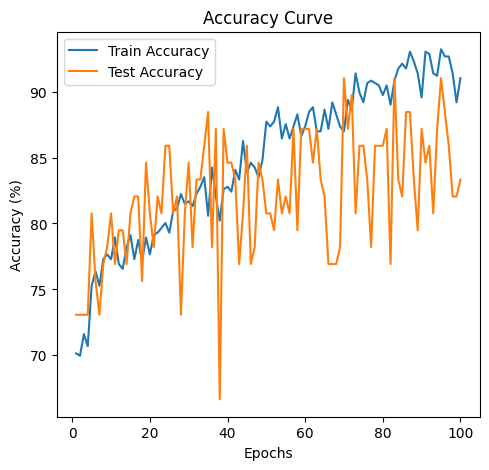

In [27]:
# Plot accuracy and loss curves
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [28]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Testing the model on the test dataset...

Final Test Results: Loss: 0.5093, Accuracy: 83.97%


# saving models 

In [27]:
# Save the trained model
MODEL_PATH = "../scriptedModels/breast_appro.pt"



# Create checkpoint dictionary
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'outputs': n_classes,  # save the model config
    'lr': lr,
    'epoch': epoch  # optionally
}

torch.save(checkpoint, MODEL_PATH)

In [25]:
#input example
dummy_input = torch.randn(1, 1, 28, 28)

# Define the ONNX file path
onnx_path = "../ONNXModels/breast2.onnx"

model.to("cpu")
# Export model to ONNX
torch.onnx.export(
    model,                        # Model to export
    dummy_input,                   # Example input
    onnx_path,                     # File path
    export_params=True,             # Store trained parameters
    # training=torch.onnx.TrainingMode.TRAINING,
    opset_version=11,               # ONNX version (11 is widely supported)
    do_constant_folding=True,       # Optimize constant folding
    input_names=["input"],          # Input tensor name
    output_names=["output"],        # Output tensor name
    dynamic_axes={                  # Support variable batch size
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

In [26]:
import onnx

# Define the ONNX file path
onnx_path = "../ONNXModels/breast2.onnx"

# Load the ONNX model
onnx_model = onnx.load(onnx_path)

# Loop through layers (nodes) in the ONNX graph
for node in onnx_model.graph.node:
    # if "res" in node.name:
        print(f"Layer Name: {node.name}")
        print(f"Operator Type: {node.op_type}")

        # Print input and output tensors for the layer
        print(f"  Inputs: {node.input}")
        print(f"  Outputs: {node.output}")
    
        print("-" * 50)  # Separator for better readability


Layer Name: /conv1/Conv
Operator Type: Conv
  Inputs: ['input', 'conv1.weight', 'conv1.bias']
  Outputs: ['/conv1/Conv_output_0']
--------------------------------------------------
Layer Name: /relu1/Relu
Operator Type: Relu
  Inputs: ['/conv1/Conv_output_0']
  Outputs: ['/relu1/Relu_output_0']
--------------------------------------------------
Layer Name: /pool/AveragePool
Operator Type: AveragePool
  Inputs: ['/relu1/Relu_output_0']
  Outputs: ['/pool/AveragePool_output_0']
--------------------------------------------------
Layer Name: /conv2/Conv
Operator Type: Conv
  Inputs: ['/pool/AveragePool_output_0', 'conv2.weight', 'conv2.bias']
  Outputs: ['/conv2/Conv_output_0']
--------------------------------------------------
Layer Name: /relu2/Relu
Operator Type: Relu
  Inputs: ['/conv2/Conv_output_0']
  Outputs: ['/relu2/Relu_output_0']
--------------------------------------------------
Layer Name: /pool2/AveragePool
Operator Type: AveragePool
  Inputs: ['/relu2/Relu_output_0']
  Outpu

In [34]:
from onnx import numpy_helper

INTIALIZERS  = onnx_model.graph.initializer
onnx_weights = {}
for initializer in INTIALIZERS:
    W = numpy_helper.to_array(initializer)
    onnx_weights[initializer.name] = W

# Print the name and weights of each parameter
# for name, weights in onnx_weights.items():
#     print(f"Layer Parameter Name: {name}")
#     print(f"  Shape: {weights.shape}")
#     print(f"  Weights: \n{weights}")
#     print("-" * 50)

# Check the shape of the weights

res_nodes = []

# Iterate through nodes and get weights & biases
for node in onnx_model.graph.node:
    print(f"Node Name (Operator): {node.op_type}")
    print(f"  Inputs: {node.input}")

    
    if 'res' in node.name:
        res_nodes.append(node)
    
    
    print("-" * 60)


for node in res_nodes:
    print("residual node:", node.name)


Node Name (Operator): Conv
  Inputs: ['input', 'onnx::Conv_67', 'onnx::Conv_68']
------------------------------------------------------------
Node Name (Operator): Constant
  Inputs: []
------------------------------------------------------------
Node Name (Operator): Pow
  Inputs: ['/conv1/Conv_output_0', '/relu1/Constant_output_0']
------------------------------------------------------------
Node Name (Operator): Constant
  Inputs: []
------------------------------------------------------------
Node Name (Operator): Mul
  Inputs: ['/relu1/Pow_output_0', '/relu1/Constant_1_output_0']
------------------------------------------------------------
Node Name (Operator): Constant
  Inputs: []
------------------------------------------------------------
Node Name (Operator): Mul
  Inputs: ['/conv1/Conv_output_0', '/relu1/Constant_2_output_0']
------------------------------------------------------------
Node Name (Operator): Add
  Inputs: ['/relu1/Mul_output_0', '/relu1/Mul_1_output_0']
-----

In [183]:
# Iterate through the initializers (weights)
for initializer in onnx_model.graph.initializer:
    print(f"Parameter Name: {initializer.name}")
    print(f"  Shape: {initializer.dims}")
    print(f"  Data Type: {initializer.data_type}")
    
    # Convert raw data to numpy array (assuming float32 data type)
    raw_data = np.frombuffer(initializer.raw_data, dtype=np.float32)
    
    # Reshape the raw data to match the dimensions of the weight (if necessary)
    raw_data = raw_data.reshape(initializer.dims)
    
    # Convert to nested list format similar to PyTorch's layer.weight.detach().tolist()
    weight_list = raw_data.tolist()
    
    # Optional: Print the first few elements for readability
    print(f"  First element [0][0][0][0] (if 4D): {weight_list[0][0][0][0] if len(initializer.dims) == 4 else weight_list[0]}")
    print(f"  Weights as list: {weight_list}...")  # Be careful: large output
    
    # Display the weights (optionally truncate or format to avoid large outputs)
    print(f"  Weights: {raw_data}...")  # Show first 10 values for readability
    print(f"  Weights: {raw_data}...")
    print("-" * 50)


Parameter Name: res1.conv1.weight
  Shape: [16, 6, 3, 3]
  Data Type: 1
  First element [0][0][0][0] (if 4D): -0.08695875108242035
  Weights as list: [[[[-0.08695875108242035, 0.07813350111246109, -0.11522287875413895], [-0.0903223380446434, -0.137116476893425, 0.07224616408348083], [0.1055281013250351, -0.09486190229654312, -0.002862116089090705]], [[-0.0408940427005291, 0.1361112743616104, 0.033559806644916534], [0.1065102219581604, 0.11728042364120483, -0.05278077349066734], [-0.11632033437490463, -0.03803697228431702, -0.05328698456287384]], [[-0.05871961638331413, 0.05210500955581665, 0.11133068054914474], [-0.08180493116378784, 0.01774294301867485, -0.07013847678899765], [0.10273132473230362, 0.03745713829994202, -0.05289267748594284]], [[0.06224885210394859, 0.035521749407052994, 0.07213684916496277], [0.049369536340236664, -0.10928944498300552, 0.12070807069540024], [-0.024946821853518486, -0.11550687998533249, 0.09826993197202682]], [[0.08704234659671783, 0.12821459770202637, 

In [27]:
m5_model = torch.load("../models/dermato_model_cam.pth", map_location=torch.device('cpu'))

/tmp/ipykernel_5395/3627536641.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m5_model = torch.load("../models/dermato_model_cam.pth", map_location=torch.device('cpu'))

FileNotFoundError: [Errno 2] No such file or directory: '../models/dermato_model_cam.pth'

In [37]:
# Loop through the model to find ResidualBlock layers
for layer_name, layer in m5_model.named_children():
    
    if isinstance(layer, ResidualBlock):  # Check if layer is ResidualBlock
        
        print(f"Found ResidualBlock: {layer_name}")
        print(f"the output channels :{layer.out_channels}")
        # Loop through the submodules inside the ResidualBlock
        for sub_layer_name, sub_layer in layer.named_children():
            
            if isinstance(sub_layer, nn.Conv2d):
                print("convolution")


            if isinstance(sub_layer, ApproxReLU):
                print(isinstance(sub_layer, ApproxReLU))
                print("relu")
              
            if sub_layer_name == 'downsample' :
                print('downsampling') 
                for sub_sub_layer in sub_layer:
                    if isinstance(sub_sub_layer, nn.Conv2d):
                        print("convolution")

                    if isinstance(sub_sub_layer, ApproxReLU):
                        print("relu")
                
            print(f"  - {sub_layer_name}: {sub_layer}")

Found ResidualBlock: res1
the output channels :16
convolution
  - conv1: Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
True
relu
  - relu1: ApproxReLU()
convolution
  - conv2: Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
downsampling
convolution
  - downsample: Sequential(
  (0): Conv2d(6, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
True
relu
  - relu2: ApproxReLU()


In [137]:
model.eval()

Lenet5(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (res1): ResidualBlock(
    (conv1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(6, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu2): ReLU()
  )
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Flatten): Flatten()
  (fc1): Linear(in_features=576, out_features=120, bias=True

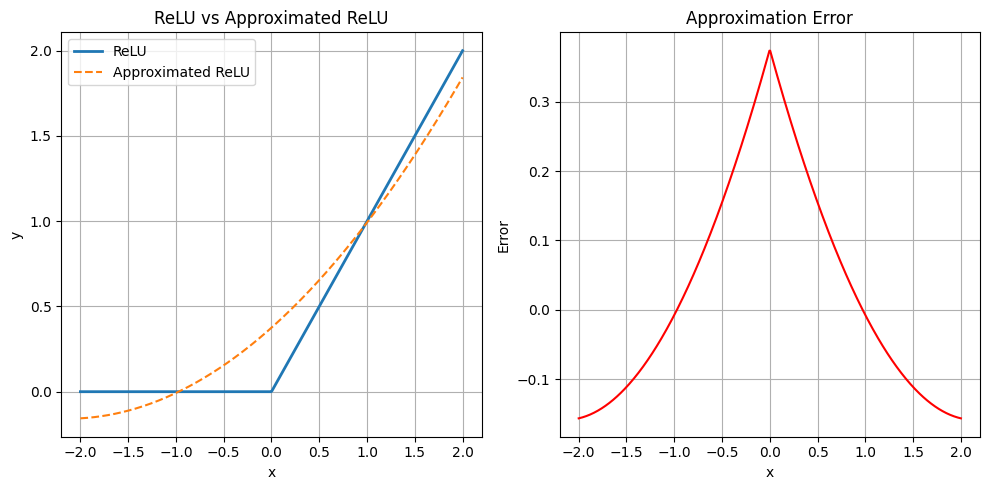

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define functions
def relu(x):
    return np.maximum(0, x)

def _approximated_ReLU(x):
    return 0.117071 * x**2 + 0.5 * x + 0.375373

# Input range
x = np.linspace(-2, 2, 500)

# Compute outputs
y_relu = relu(x)
y_approx = _approximated_ReLU(x)
error = y_approx - y_relu

# Plot ReLU and approximation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y_relu, label="ReLU", linewidth=2)
plt.plot(x, y_approx, label="Approximated ReLU", linestyle='--')
plt.title("ReLU vs Approximated ReLU")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# Plot error
plt.subplot(1, 2, 2)
plt.plot(x, error, label="Error (Approx - ReLU)", color="red")
plt.title("Approximation Error")
plt.xlabel("x")
plt.ylabel("Error")
plt.grid(True)

plt.tight_layout()
plt.show()


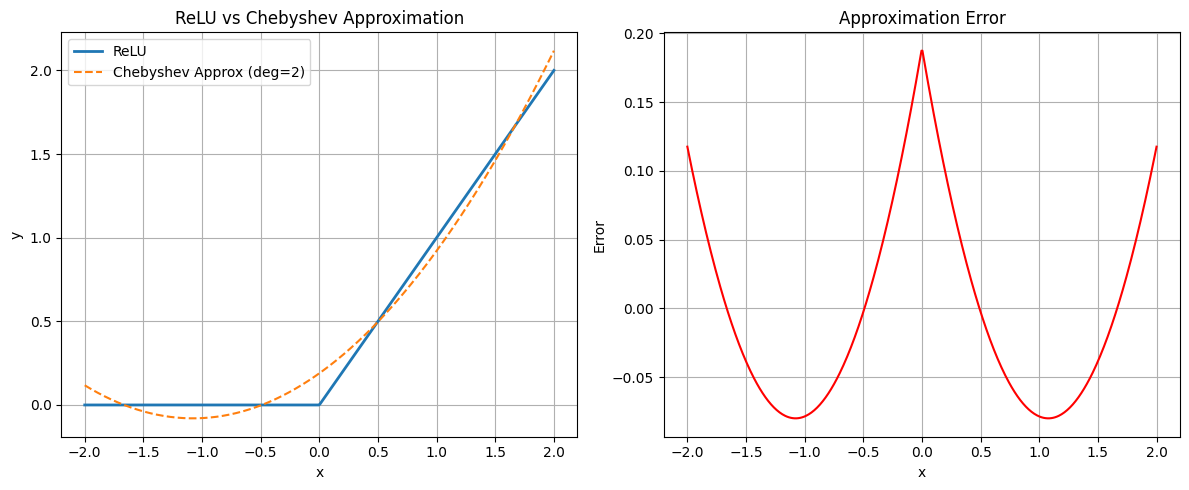

Chebyshev coefficients (degree 2): [0.30542117 0.5        0.11602723]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.chebyshev import Chebyshev

# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Define the interval and sample points
x = np.linspace(-2, 2, 500)
y_relu = relu(x)

# Create Chebyshev approximation of degree 2 on [-2, 2]
# Fit the Chebyshev polynomial using 100 sample points
x_fit = np.linspace(-2, 2, 100)# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
y_fit = relu(x_fit)
cheb_fit = Chebyshev.fit(x_fit, y_fit, deg=2, domain=[-2, 2])

# Evaluate the approximation
y_approx = cheb_fit(x)
error = y_approx - y_relu

# Plot ReLU vs Chebyshev approximation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y_relu, label="ReLU", linewidth=2)
plt.plot(x, y_approx, label="Chebyshev Approx (deg=2)", linestyle='--')
plt.title("ReLU vs Chebyshev Approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# Plot the error
plt.subplot(1, 2, 2)
plt.plot(x, error, label="Error (Approx - ReLU)", color="red")
plt.title("Approximation Error")
plt.xlabel("x")
plt.ylabel("Error")
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Print the coefficients
print("Chebyshev coefficients (degree 2):", cheb_fit.convert().coef)


Minimax Degree-2 Polynomial Coefficients:
p(x) = -0.055921 + 0.140319 * x + 0.269482 * x^2


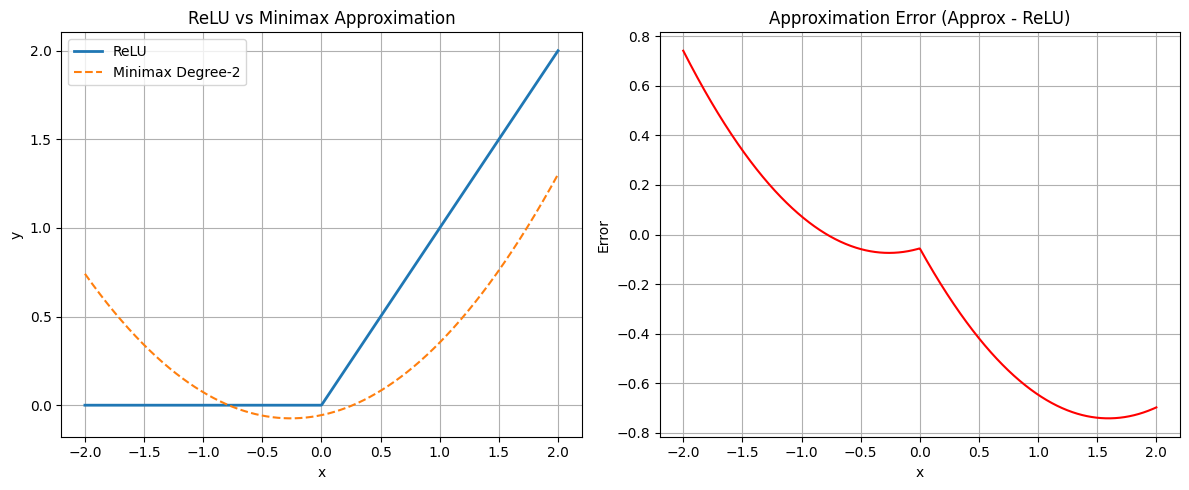

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define ReLU
def relu(x):
    return np.maximum(0, x)

# Define polynomial of degree 2: p(x) = a0 + a1*x + a2*x^2
def poly2(x, coeffs):
    return coeffs[0] + coeffs[1]*x + coeffs[2]*x**2

# Define objective: maximum absolute error over [-2, 2]
def max_error(coeffs, x, y_true):
    y_pred = poly2(x, coeffs)
    return np.max(np.abs(y_pred - y_true))

# Input domain
x = np.linspace(-2, 2, 1000)
y = relu(x)

# Initial guess for coefficients
initial_coeffs = [0.0, 0.0, 0.0]

# Minimize the maximum error (minimax approximation)
result = minimize(lambda c: max_error(c, x, y), initial_coeffs, method='Nelder-Mead')

# Optimal coefficients
opt_coeffs = result.x
print("Minimax Degree-2 Polynomial Coefficients:")
print(f"p(x) = {opt_coeffs[0]:.6f} + {opt_coeffs[1]:.6f} * x + {opt_coeffs[2]:.6f} * x^2")

# Plot the results
y_approx = poly2(x, opt_coeffs)
error = y_approx - y

plt.figure(figsize=(12, 5))

# ReLU vs approximation
plt.subplot(1, 2, 1)
plt.plot(x, y, label="ReLU", linewidth=2)
plt.plot(x, y_approx, label="Minimax Degree-2", linestyle='--')
plt.title("ReLU vs Minimax Approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# Error plot
plt.subplot(1, 2, 2)
plt.plot(x, error, color='red')
plt.title("Approximation Error (Approx - ReLU)")
plt.xlabel("x")
plt.ylabel("Error")
plt.grid(True)

plt.tight_layout()
plt.show()
